In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
from typing import List
import time

In [2]:
env = gym.make("CartPole-v1"
            #    , render_mode="human"
               )

In [3]:
print(f"this is observation space: {type(env.observation_space)}")
print(f"this is action space: {env.action_space}")

# 0: cart position 1: cart velocity 2: pole angle 3: pole angular velocity
# observation high represents the highest value that the observation can take
print(f"this is observation space high: {env.observation_space.high}")
upper_bound = env.observation_space.high.tolist()

# observation lowest represents the lowest value that the observation can take
print(f"this is observation space low: {env.observation_space.low}")
lower_bound = env.observation_space.low.tolist()

this is observation space: <class 'gym.spaces.box.Box'>
this is action space: Discrete(2)
this is observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
this is observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [4]:
def random_seed() -> int:
    return random.randint(0, 10000)

seed = random_seed()
print(f"this is the seed: {seed}")
env.action_space.seed(seed)
state = env.reset()[0]
print(state)
print(state[0])
print(env.step(0)[0])

# print(type(env))
# print(env.action_space.n)
# print(env.observation_space.shape)
# print(env.observation_space.shape[0])

this is the seed: 5422
[ 0.02491105  0.03548885 -0.01966211 -0.02125973]
0.024911053
[ 0.02562083 -0.15934569 -0.02008731  0.26515532]


c:\Users\Ng Jing En\miniconda3\envs\SC3000\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Task 1: need to choose corresponding action according to state of the cartpole

##### Task 1.1: getting discrete state

State space in cart pole is infinite, which means it is continuous

hence we need to discretise the state space if not there will be infinite rows in the state space table

We will need to discretise each state variable into n segments

potentially have many different states being mapped into 1 state, but we can make the states finer inorder to reduce the amount of different states being sent into this table

In [5]:
# Map continuous state to discrete indices for Q-matrix
def discretiser(
        state: List[float], 
        number_of_bins: List[int], 
        lower_bounds: List[float], 
        upper_bounds:List[float]
        ) -> tuple:
    """
    Discretise the continuous state into discrete indices for the Q-matrix
    
    Args:
    state: List of continuous state variables
    number_of_bins: Number of bins to divide each state variable
    lower_bounds: Lower bounds for each state variable
    upper_bounds: Upper bounds for each state variable
    
    Returns:
    Tuple of indices for each state variable
    """
    cart_position_bin = np.linspace(lower_bounds[0], upper_bounds[0], number_of_bins[0])
    cart_velocity_bin = np.linspace(lower_bounds[1], upper_bounds[1], number_of_bins[1])
    pole_angle_bin = np.linspace(lower_bounds[2], upper_bounds[2], number_of_bins[2])
    pole_angle_velocity_bin = np.linspace(lower_bounds[3], upper_bounds[3], number_of_bins[3])
    
    index_position = np.maximum(np.digitize(state[0], cart_position_bin) - 1, 0)
    index_velocity = np.maximum(np.digitize(state[1], cart_velocity_bin) - 1, 0)
    index_angle = np.maximum(np.digitize(state[2], pole_angle_bin) - 1, 0)
    index_angular_velocity = np.maximum(np.digitize(state[3], pole_angle_velocity_bin) - 1, 0)
    
    return tuple([index_position, index_velocity, index_angle, index_angular_velocity])


##### Task 1.2: initialise Q-learning

In [6]:
# Initialize the Q-learning parameters and Q-matrix
def initialize_q_learning(
        env, 
        number_of_bins: List[int]
        ) -> tuple:
    """
    Initialize the Q-learning parameters and Q-matrix
    
    Args:
    env: Gym environment
    number_of_bins: Number of bins to divide each state variable
    
    Returns:
    Q-matrix and list to store sum of rewards for each episode
    """
    action_number = env.action_space.n
    # Q-matrix initialized with random values between 0 and 1
    q_matrix = np.random.uniform(low=0, high=1, 
                                size=(number_of_bins[0], number_of_bins[1], 
                                      number_of_bins[2], number_of_bins[3], 
                                      action_number))
    # List to store sum of rewards for each episode
    sum_rewards_episode = []
    
    return q_matrix, sum_rewards_episode

##### Task 1.3: selection of action

In [7]:
def select_action(
        state:tuple , 
        index: int, 
        q_matrix, 
        action_number: int, 
        epsilon: float, 
        number_of_bins: List[int], 
        lower_bounds: List[float], 
        upper_bounds: List[float]
        ) -> int:
    """
    Select an action using the epsilon-greedy strategy.

    Parameters:
    state (array-like): The current state of the environment.
    index (int): The current episode index.
    q_matrix (ndarray): The Q-value matrix.
    action_number (int): The total number of possible actions.
    epsilon (float): The exploration rate.
    number_of_bins (int): The number of bins for discretizing the state space.
    lower_bounds (array-like): The lower bounds for each dimension of the state space.
    upper_bounds (array-like): The upper bounds for each dimension of the state space.

    Returns:
    int: The selected action.
    """
    # First 500 episodes: select completely random actions for exploration
    if index < 500:
        return np.random.choice(action_number)
    
    # After 7000 episodes: gradually decrease epsilon
    if index > 7000:
        epsilon = 0.999 * epsilon
    
    # Explore (random action) with probability epsilon
    if np.random.random() < epsilon:
        return np.random.choice(action_number)
    
    # Exploit (greedy action) with probability 1-epsilon
    state_index = discretiser(state, number_of_bins, lower_bounds, upper_bounds)
    # Find action(s) with maximum Q-value
    max_actions = np.where(q_matrix[state_index] == np.max(q_matrix[state_index]))[0]
    # Randomly choose one if multiple actions have the same max value
    return np.random.choice(max_actions)

In [8]:
def simulate_episodes(
        env, 
        alpha: float, 
        gamma: float, 
        epsilon: float, 
        number_episodes: int, 
        number_of_bins: List[int], 
        lower_bounds: List[float], 
        upper_bounds: List[float]
        ) -> tuple:
    """
    Simulates a number of episodes using Q-learning algorithm.

    Parameters:
    env (gym.Env): The environment to simulate.
    alpha (float): The learning rate.
    gamma (float): The discount factor.
    epsilon (float): The exploration rate.
    number_episodes (int): The number of episodes to simulate.
    number_of_bins (int): The number of bins to discretize the state space.
    lower_bounds (list): The lower bounds for each state dimension.
    upper_bounds (list): The upper bounds for each state dimension.

    Returns:
    tuple: A tuple containing the Q-matrix and a list of sum of rewards per episode.
    """
    q_matrix, sum_rewards_episode = initialize_q_learning(env, number_of_bins)
    
    for index_episode in range(number_episodes):
        # List to store rewards for this episode
        rewards_episode = []
        
        # Reset environment at the beginning of each episode
        (state_s, _) = env.reset()
        state_s = list(state_s)
        
        print(f"Simulating episode {index_episode}")
        
        # Run episode until terminal state is reached
        terminal_state = False
        while not terminal_state and np.sum(rewards_episode) < 500:
            # Get the discretized index of current state
            state_s_index = discretiser(state_s, number_of_bins, lower_bounds, upper_bounds)
            
            # Select action based on current state
            action_a = select_action(state_s, index_episode, q_matrix, env.action_space.n, 
                                    epsilon, number_of_bins, lower_bounds, upper_bounds)
            
            # Take action and get next state and reward
            (state_s_prime, reward, terminal_state, _, _) = env.step(action_a)
            rewards_episode.append(reward)
            state_s_prime = list(state_s_prime)
            
            # Get index for next state
            state_s_prime_index = discretiser(state_s_prime, number_of_bins, lower_bounds, upper_bounds)
            
            # Get max Q-value for next state
            q_max_prime = np.max(q_matrix[state_s_prime_index])
            
            # Update Q-matrix using Bellman equation
            if not terminal_state:
                error = reward + gamma * q_max_prime - q_matrix[state_s_index + (action_a,)]
            else:
                error = reward - q_matrix[state_s_index + (action_a,)]
                
            q_matrix[state_s_index + (action_a,)] = q_matrix[state_s_index + (action_a,)] + alpha * error
            
            # Set current state to next state
            state_s = state_s_prime
        
        # Print and save episode rewards
        print(f"Sum of rewards {np.sum(rewards_episode)}")
        sum_rewards_episode.append(np.sum(rewards_episode))
    
    return q_matrix, sum_rewards_episode

In [10]:
def train_q_learning(
        env, alpha: float, 
        gamma: float, 
        epsilon: float, 
        number_episodes: int, 
        number_of_bins: List[int], 
        lower_bounds: List[float], 
        upper_bounds: List[float]
        ) -> tuple:
    """
    Train the Q-learning agent.
    
    Parameters:
    env (gym.Env): The environment to train the agent on.
    alpha (float): The learning rate.
    gamma (float): The discount factor.
    epsilon (float): The exploration rate.
    number_episodes (int): The number of episodes to train the agent.
    number_of_bins (list): The number of bins for discretizing the state space.
    lower_bounds (list): The lower bounds for each state dimension.
    upper_bounds (list): The upper bounds for each state dimension.
    
    Returns:
    tuple: A tuple containing the Q-matrix and the rewards history.
    """
    # Train the agent
    print("Starting Q-learning training...")
    q_matrix, rewards_history = simulate_episodes(
        env, alpha, gamma, epsilon, number_episodes, 
        number_of_bins, lower_bounds, upper_bounds
    )
    return q_matrix, rewards_history

Starting Q-learning training...
Simulating episode 0
Sum of rewards 20.0
Simulating episode 1
Sum of rewards 12.0
Simulating episode 2
Sum of rewards 16.0
Simulating episode 3
Sum of rewards 24.0
Simulating episode 4
Sum of rewards 18.0
Simulating episode 5
Sum of rewards 12.0
Simulating episode 6
Sum of rewards 21.0
Simulating episode 7
Sum of rewards 27.0
Simulating episode 8
Sum of rewards 17.0
Simulating episode 9
Sum of rewards 20.0
Simulating episode 10
Sum of rewards 11.0
Simulating episode 11
Sum of rewards 13.0
Simulating episode 12
Sum of rewards 22.0
Simulating episode 13
Sum of rewards 22.0
Simulating episode 14
Sum of rewards 40.0
Simulating episode 15
Sum of rewards 36.0
Simulating episode 16
Sum of rewards 15.0
Simulating episode 17
Sum of rewards 11.0
Simulating episode 18
Sum of rewards 21.0
Simulating episode 19
Sum of rewards 34.0
Simulating episode 20
Sum of rewards 19.0
Simulating episode 21
Sum of rewards 20.0
Simulating episode 22
Sum of rewards 35.0
Simulating e

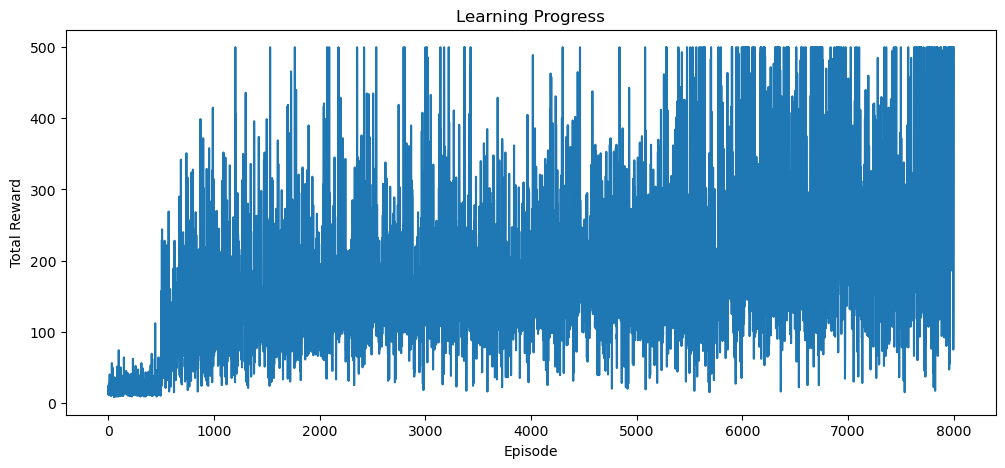

In [11]:
# 1. Create CartPole environment
env = gym.make('CartPole-v1')

# 2. Define Q-learning parameters
alpha = 0.20         # Learning rate
gamma = 0.99            # Discount factor
epsilon = 0.2        # Initial exploration rate
number_episodes = 8000  # Total number of training episodes

# 3. Define discretisation parameters
# Number of bins for discretizing each state dimension
number_of_bins = [10, 10, 10, 10]  

# Define bounds for state variables
lower_bounds = [-2.4, -2, -0.2, -1.5]
upper_bounds = [2.4, 2, 0.2, 1.5]

# 4. Train the agent
q_matrix, rewards_history = train_q_learning(
    env, alpha, gamma, epsilon, number_episodes, 
    number_of_bins, lower_bounds, upper_bounds
)

# 5. Plot learning progress
plt.figure(figsize=(12, 5))
plt.plot(rewards_history)
plt.title('Learning Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


In [ ]:
def test_q_learning(q_matrix, env, number_of_bins:List[int], lower_bounds:List[float], upper_bounds:List[float]) -> int:
    """
    Testing the Q-learning agent.
    
    Parameters:
    q_matrix (ndarray): The Q-value matrix.
    env (gym.Env): The environment to test the agent on.
    number_of_bins (list): The number of bins for discretizing the state space.
    lower_bounds (list): The lower bounds for each state dimension.
    upper_bounds (list): The upper bounds for each state dimension.
    
    Returns:
    int: Total reward obtained during testing of a single episode.
    """
    
    # Test the trained agent
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        env.render()
        state_discrete = discretiser(state, number_of_bins, lower_bounds, upper_bounds)
        action = np.argmax(q_matrix[state_discrete])
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    env.close()
    return total_reward

Total reward during testing: 185.0


### Task 2: run the RL agent 100 times, reset state at the start of each iteration 

Average cumulative reward: 201.02
Is my agent good enough? True


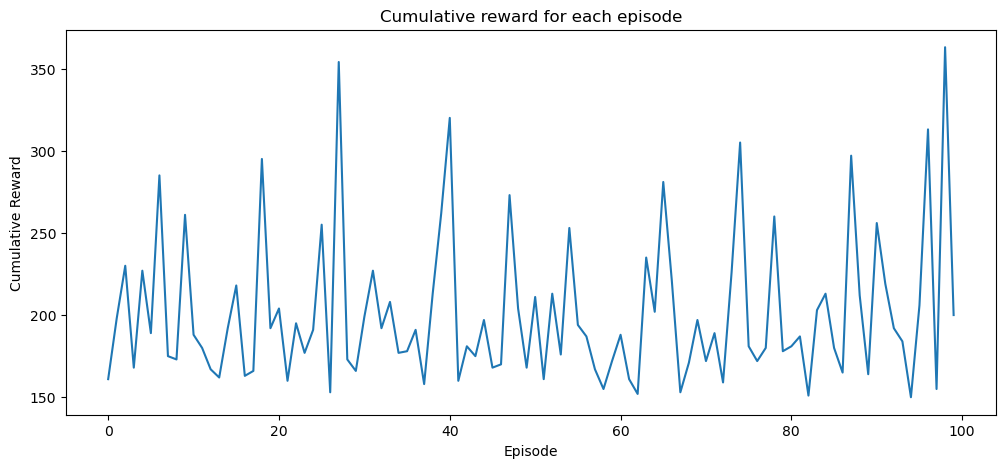

In [ ]:
rewards_history = []
for episode in range(100):
    total_reward = test_q_learning(q_matrix, env, number_of_bins, lower_bounds, upper_bounds)
    rewards_history.append(total_reward)

average_total_reward = np.mean(rewards_history)
print(f'Average cumulative reward: {average_total_reward}')
print(f'Is my agent good enough? {average_total_reward > 195}')

plt.figure(figsize=(12, 5))
plt.plot(rewards_history)
plt.title('Cumulative reward for each episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

### Task 3: Render one episode played by the developed RL agent on Jupyter.

In [42]:
def view_q_learning(q_matrix, env, number_of_bins, lower_bounds, upper_bounds):

    done = False
    total_reward = 0
    while not done:
        env.render()
        state_discrete = discretiser(state, number_of_bins, lower_bounds, upper_bounds)
        action = np.argmax(q_matrix[state_discrete])
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    env.close()
    return total_reward


In [32]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")


In [43]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
view_q_learning(q_matrix, env, number_of_bins, lower_bounds, upper_bounds)
show_video()

ResetNeeded: Cannot call `env.render()` before calling `env.reset()`, if this is a intended action, set `disable_render_order_enforcing=True` on the OrderEnforcer wrapper.